# Goals

Assess correlation of stimulations between technical replicates in SIG13. We will assess both the total LFC (β1+β2+β3) and the interaction LFC (β3)

# Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42
plt.rcParams['text.usetex']  = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# import total lfc values
singleCoeff = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_single_term/glmGamPoi_coefficients_0.2filter.csv")
singleLfc = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_single_term/glmGamPoi_singleTerm_lfc_0.2filter.csv")
singleLfcReplicates = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_single_term_independent_replicates/glmGamPoi_singleTerm_lfc_independent_replicates_0.2filter.csv")

# import interaction lfc values
interCoeff = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_interaction/glmGamPoi_coefficients_0.2filter.csv")
interScored = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_interaction/interactions_scored_v2_glmGamPoi_0.2filter_sig.csv")
interLfcReplicates = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_interaction_independent_replicates/glmGamPoi_interaction_lfc_independent_replicates_0.2filter.csv")

# Total LFC Correlations

Calculate and plot correlation of total LFC for significant DEGs between technical replicates.

In [7]:
def pairwise_cor_single(singleLfc: pd.DataFrame,
                       pval_cutoff: float) -> pd.DataFrame:
    """
    For each condition, compute Pearson correlation of lfc_rep1 vs lfc_rep2. Correlations
    are calculated using genes that are significant in at least one replicate.
    
    Returns a DataFrame with columns: condition, pearson_corr, num_shared_genes.
    """
    # 1) one‐time pivot
    wide = (
        singleLfc
        .set_index(['condition','name','replicate'])[['lfc','adj_pval']]
        .unstack('replicate')
    )
    wide.columns = [f"{var}_{rep}" for var,rep in wide.columns]
    wide = wide.reset_index()

    # 2) count genes significant in *both* reps
    both_sig = (wide['adj_pval_rep1'] < pval_cutoff) & (wide['adj_pval_rep2'] < pval_cutoff)
    gene_num = (
        wide.loc[both_sig]
        .groupby('condition')
        .size()
        .reset_index(name='num_shared_genes')
    )

    # 3) keep genes significant in *either* rep, drop missing LFCs
    either_sig = ((wide['adj_pval_rep1'] < pval_cutoff) |
                  (wide['adj_pval_rep2'] < pval_cutoff))
    wide = wide.loc[either_sig].dropna(subset=['lfc_rep1','lfc_rep2'])

    # 4) compute Pearson *only* on the two LFC columns
    corrs = (
        wide
        .groupby('condition')[['lfc_rep1','lfc_rep2']]
        .apply(lambda df: df['lfc_rep1'].corr(df['lfc_rep2']))
        .reset_index(name='pearson_corr')
    )

    # 5) re‐attach the gene counts
    return corrs.merge(gene_num, on='condition', how='left')

In [8]:
# get correlation between replicates for single ligand effects
singleRepCor = pairwise_cor_single(singleLfcReplicates, pval_cutoff=0.1)
# replace NaNs with 0
singleRepCor['num_shared_genes'] = singleRepCor['num_shared_genes'].fillna(0)
singleRepCor['pearson_corr'] = singleRepCor['pearson_corr'].fillna(0)
singleRepCor['num_shared_genes_log10'] = np.log10(singleRepCor['num_shared_genes'] + 1)

singleScoredSummary = (singleLfc
                       .query('adj_pval < 0.1')
                       .groupby('condition')
                       .size()
                       .reset_index(name='num_degs'))

# merge with single ligand correlation results
singleRepCor = singleRepCor.merge(singleScoredSummary, on='condition', how='left')
# replace NaNs with 0
singleRepCor['num_degs'] = singleRepCor['num_degs'].fillna(0)
singleRepCor['num_degs_log10'] = np.log10(singleRepCor['num_degs'] + 1)

/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


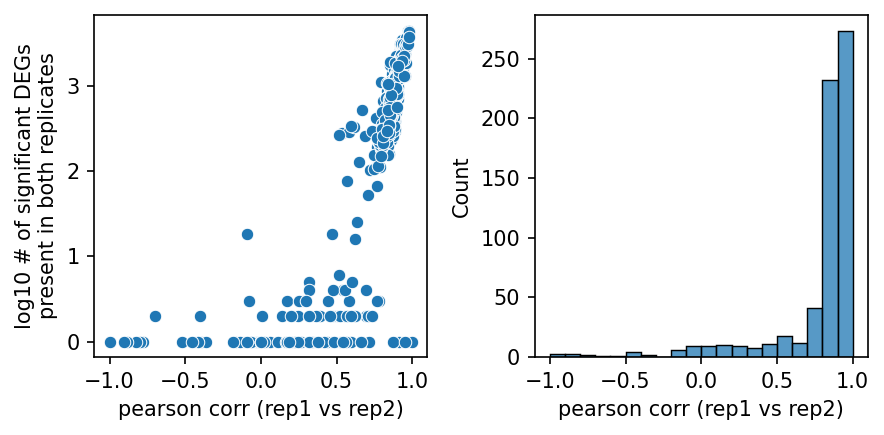

In [9]:
# Create side-by-side plots for single ligand effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

# First plot - scatter plot
sns.scatterplot(
    data=singleRepCor,
    x='pearson_corr',
    y='num_shared_genes_log10',
    ax=ax1
)
ax1.set_ylabel("log10 # of significant DEGs\npresent in both replicates")
ax1.set_xlabel("pearson corr (rep1 vs rep2)")

# Second plot - histogram of correlations
sns.histplot(
    data=singleRepCor,
    x='pearson_corr',
    bins=20,
    ax=ax2
)
ax2.set_xlabel("pearson corr (rep1 vs rep2)")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.savefig("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/plots/qc/replicate_corr_all_deg.pdf", bbox_inches='tight')
plt.show()

In [10]:
singleRepCor.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/replicate_corr/replicate_correlation_singleLfc_0.2filter.csv",
                   index=False)

# Interaction LFC Correlations

Calculate and plot interaction LFC correlation for significant DEGs between technical replicates.

In [11]:
def pairwise_cor_inter(interLfc: pd.DataFrame,
                       pval_cutoff: float) -> pd.DataFrame:
    """
    For each interaction, compute Pearson correlation of lfc_rep1 vs lfc_rep2. Correlations
    are calculated using genes that are significant in at least one replicate.
    
    Returns a DataFrame with columns: interaction, pearson_corr, num_shared_genes.
    """
    # 1) one‐time pivot
    wide = (
        interLfc
        .set_index(['interaction','name','replicate'])[['lfc','adj_pval']]
        .unstack('replicate')
    )
    wide.columns = [f"{var}_{rep}" for var,rep in wide.columns]
    wide = wide.reset_index()

    # 2) count genes significant in *both* reps
    both_sig = (wide['adj_pval_rep1'] < pval_cutoff) & (wide['adj_pval_rep2'] < pval_cutoff)
    gene_num = (
        wide.loc[both_sig]
        .groupby('interaction')
        .size()
        .reset_index(name='num_shared_genes')
    )

    # 3) keep genes significant in *either* rep, drop missing LFCs
    either_sig = ((wide['adj_pval_rep1'] < pval_cutoff) |
                  (wide['adj_pval_rep2'] < pval_cutoff))
    wide = wide.loc[either_sig].dropna(subset=['lfc_rep1','lfc_rep2'])

    # 4) compute Pearson *only* on the two LFC columns
    corrs = (
        wide
        .groupby('interaction')[['lfc_rep1','lfc_rep2']]
        .apply(lambda df: df['lfc_rep1'].corr(df['lfc_rep2']))
        .reset_index(name='pearson_corr')
    )

    # 5) re‐attach the gene counts
    return corrs.merge(gene_num, on='interaction', how='left')

In [12]:
# get correlation between replicates
interRepCor = pairwise_cor_inter(interLfcReplicates, pval_cutoff=0.1)
# replace NaNs with 0
interRepCor['num_shared_genes'] = interRepCor['num_shared_genes'].fillna(0)
interRepCor['num_shared_genes_log10'] = np.log10(interRepCor['num_shared_genes'])

# calculate number of significant gene interactions per interaction with bulk GLM data
interScoredSummary = (interScored
                      .query('adj_pval_interaction < 0.1')
                      .groupby('interaction')
                      .size()
                      .reset_index(name='num_genes_interacting'))

# merge with interaction coefficients
interRepCor = interRepCor.merge(interScoredSummary, on='interaction', how='left')
# replace NaNs with 0
interRepCor['num_genes_interacting'] = interRepCor['num_genes_interacting'].fillna(0)
interRepCor['num_genes_interacting_log10'] = np.log10(interRepCor['num_genes_interacting'])

/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*

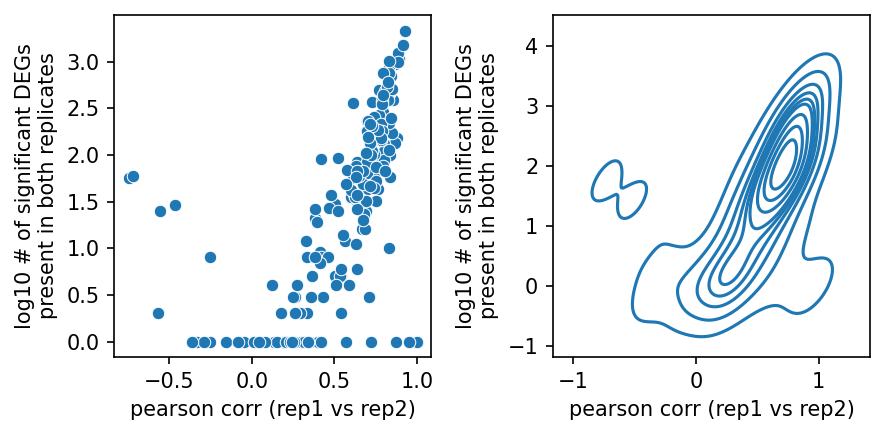

In [13]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# First plot - scatter plot
sns.scatterplot(
    data=interRepCor,
    x='pearson_corr',
    y='num_shared_genes_log10',
    ax=ax1
)
ax1.set_ylabel("log10 # of significant DEGs\npresent in both replicates")
ax1.set_xlabel("pearson corr (rep1 vs rep2)")

# Second plot - KDE plot
sns.kdeplot(
    data=interRepCor,
    x='pearson_corr',
    y='num_shared_genes_log10',
    ax=ax2
)
ax2.set_ylabel("log10 # of significant DEGs\npresent in both replicates")
ax2.set_xlabel("pearson corr (rep1 vs rep2)")

plt.tight_layout()
plt.show()

In [14]:
# export interaction correlations
interRepCor.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/replicate_corr/replicate_correlation_interactionLfc_0.2filter.csv",
                   index=False)